In [3]:
!pip install geopandas contextily shapely


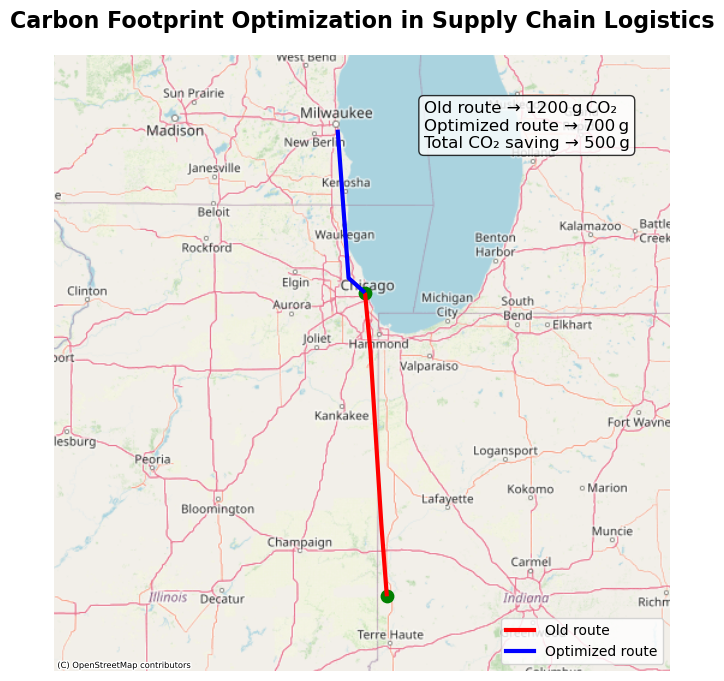

In [20]:
# 📍 Carbon Footprint Route Visualization with Basemap & Markers
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path

# 📦 Utility to make bounding box square (prevents skinny maps)
def square_bounds(ax, pad_ratio=0.10):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    dx, dy = xmax - xmin, ymax - ymin
    if dx > dy:
        extra = (dx - dy) / 2
        ymin -= extra
        ymax += extra
    else:
        extra = (dy - dx) / 2
        xmin -= extra
        xmax += extra
    pad_x = (xmax - xmin) * pad_ratio
    pad_y = (ymax - ymin) * pad_ratio
    ax.set_xlim(xmin - pad_x, xmax + pad_x)
    ax.set_ylim(ymin - pad_y, ymax + pad_y)


# ----1.Load route data -----
data_path = next(
    (Path(p) for p in ("route_points.csv", "route_points.xlsx") if Path(p).exists()),
    None,
)
if data_path is None:
    raise FileNotFoundError("Put 'route_points.csv' or 'route_points.xlsx' beside this notebook.")

route_data = (
    pd.read_csv(data_path)
    if data_path.suffix.lower() == ".csv"
    else pd.read_excel(data_path)
)

required = {"lat", "lon", "route_type"}
if not required.issubset(route_data.columns):
    raise ValueError(f"Route file must contain columns {required}.")

old_route = route_data.query("route_type == 'old'").sort_index()
opt_route = route_data.query("route_type == 'optimized'").sort_index()

# ── 2. CO₂ numbers (replace with model output if available) ───────────────
old_emission, opt_emission = 1200, 700  # grams
saving = old_emission - opt_emission

# ── 3. Try GeoPandas + Contextily for basemap ─────────────────────────────
try:
    import geopandas as gpd
    import contextily as ctx
    from shapely.geometry import LineString

    # Build GeoDataFrames in Web‑Mercator
    gdf_old = gpd.GeoDataFrame(geometry=gpd.points_from_xy(old_route.lon, old_route.lat), crs="EPSG:4326").to_crs(3857)
    gdf_opt = gpd.GeoDataFrame(geometry=gpd.points_from_xy(opt_route.lon, opt_route.lat), crs="EPSG:4326").to_crs(3857)

    line_old = gpd.GeoSeries([LineString(gdf_old.geometry.tolist())], crs=gdf_old.crs)
    line_opt = gpd.GeoSeries([LineString(gdf_opt.geometry.tolist())], crs=gdf_opt.crs)

    fig, ax = plt.subplots(figsize=(10, 8))
    line_old.plot(ax=ax, color="red",  linewidth=3, label="Old route")
    line_opt.plot(ax=ax, color="blue", linewidth=3, label="Optimized route")

    # Start & end pins
    gdf_old.geometry.iloc[[0, -1]].plot(ax=ax, color="green", markersize=80)


    square_bounds(ax)  # Adjusts axis so map fills the figure nicely

    # ── Basemap with fallback providers ───────────────────────────────────
    tile_providers = [
        ctx.providers.OpenStreetMap.Mapnik,
        ctx.providers.CartoDB.Positron,
        ctx.providers.Stamen.Terrain,
    ]
    for provider in tile_providers:
        try:
            ctx.add_basemap(ax, source=provider, attribution_size=6)
            break
        except Exception as e:
            print(f"⚠️  {provider.name} failed → {e}")
    else:
        print("⚠️  All basemap providers failed – using blank background.")

    ax.set_axis_off()

except ImportError:
    # ── 4. Fallback: plain Matplotlib (no basemap) ───────────────────────
    plt.figure(figsize=(20, 15))
    plt.plot(old_route.lon, old_route.lat, "r-", lw=3, label="Old route")
    plt.plot(opt_route.lon, opt_route.lat, "b-", lw=3, label="Optimized route")
    plt.scatter(
        [old_route.lon.iloc[0], old_route.lon.iloc[-1]],
        [old_route.lat.iloc[0], old_route.lat.iloc[-1]],
        c="green", s=80,
    )
    plt.xticks([]); plt.yticks([])
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

# ── 5. Annotation & legend ────────────────────────────────────────────────
text = (
    f"Old route → {old_emission} g CO₂\n"
    f"Optimized route → {opt_emission} g\n"
    f"Total CO₂ saving → {saving} g"
)
plt.gca().text(
    0.60, 0.85, text, transform=plt.gca().transAxes,
    fontsize=12, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.title("Carbon Footprint Optimization in Supply Chain Logistics", fontsize=16, weight="bold", pad=20)
plt.legend(
    [Line2D([0], [0], color="red", lw=3), Line2D([0], [0], color="blue", lw=3)],
    ["Old route", "Optimized route"], loc="lower right",
)
plt.show()
